In [1]:
# %load_ext nb_black
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics as m
import xgboost as xgb
import seaborn as sns
warnings.filterwarnings("ignore")
random_seed = 8
from matplotlib import pyplot as plt

In [2]:
cols=['Unnamed: 0','FIELD_1','FIELD_2','AGE','SEX','FIELD_15','FIELD_38', 'FIELD_33', 'L100700','S000300', 
'L101700','L100800','L103300', 'L103100','L190900','L504700', 
'L190300', 'L103000']

In [3]:
newdata=pd.read_csv('../DATASET_2019-10-24_light.txt')[['FIELD_1','FIELD_2','CLASS']]

In [4]:
x_original=pd.read_csv('../_XLable_forischemic.txt').drop(columns=['CLASS'])[cols]
y_original=pd.read_csv('../_TargetLable_forischemic.txt').drop(columns=['CLASS'])[cols]

In [5]:
x_original=pd.merge(x_original,newdata,how='inner', left_on=['FIELD_1','FIELD_2'], right_on=['FIELD_1','FIELD_2'])
x_original.shape

(193691, 19)

In [6]:
y_original=pd.merge(y_original,newdata,how='inner', left_on=['FIELD_1','FIELD_2'], right_on=['FIELD_1','FIELD_2'])
y_original.shape

(193691, 19)

In [58]:
data = pd.merge(
    x_original, y_original, how="inner", left_on="Unnamed: 0", right_on="Unnamed: 0"
).dropna()
data.shape
data.groupby(by='CLASS_y').size()

CLASS_y
0    119478
1       879
dtype: int64

In [59]:
cols=['AGE','SEX','FIELD_15','FIELD_38', 'FIELD_33', 'L100700','S000300', 
'L101700','L100800','L103300', 'L103100','L190900','L504700', 
'L190300', 'L103000']

In [60]:
xcols=[]
ycols=[]

for i in cols:
    xcols.append (i+'_x')
#     ycols.append (i+'_y')

In [61]:
maindata=data.copy()

class0=maindata[maindata.CLASS_y==0]
class1=maindata[maindata.CLASS_y==1]

class0=class0.sample(30*class1.shape[0],random_state=42)

data=pd.concat([class0,class1])
print(data.shape)
data.groupby(by='CLASS_y').size()

(27249, 37)


CLASS_y
0    26370
1      879
dtype: int64

In [62]:
data.shape

(27249, 37)

In [63]:
# x = data[xcols]
# y = data[['CLASS_y']]
# xtrain, xtest, ytrain, ytest = train_test_split(x, y, random_state=42, test_size=0.3)


test=pd.concat([data[data.CLASS_y==0].sample(50,random_state=42),
               data[data.CLASS_y==1].sample(50,random_state=42)])           
train=data.drop(test.index)

xtrain=train[xcols] 
xtest=test[xcols] 
ytrain=train[['CLASS_y']].CLASS_y
ytest=test[['CLASS_y']].CLASS_y

print(xtrain.shape,xtest.shape,ytrain.shape,ytest.shape)

(27149, 15) (100, 15) (27149,) (100,)


In [65]:
from imblearn.over_sampling import SMOTE, SMOTENC  # doctest: +NORMALIZE_WHITESPACE
from collections import Counter

randomseed = 42

sm = SMOTE(
    random_state=randomseed,
#     categorical_features=[6, 7, 8, 9, 10],
    sampling_strategy="minority",k_neighbors=45
)
X_res, y_res = sm.fit_resample(xtrain, ytrain)

print(
    y_res[y_res == 0].shape[0], y_res[y_res == 1].shape[0]
)

print("Resampled dataset shape %s" % Counter(y_res))
print(
    y_res[y_res == 0].shape[0], y_res[y_res == 1].shape[0]
)
print(X_res.shape, y_res.shape)

xtrain = X_res
ytrain = y_res

26320 26320
Resampled dataset shape Counter({0: 26320, 1: 26320})
26320 26320
(52640, 15) (52640,)


In [66]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    random_state=42,
    n_estimators=50,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=10,
    max_features=8,
)
rf.fit(xtrain, ytrain)

RandomForestClassifier(max_depth=10, max_features=8, min_samples_leaf=10,
                       n_estimators=50, random_state=42)

0.51


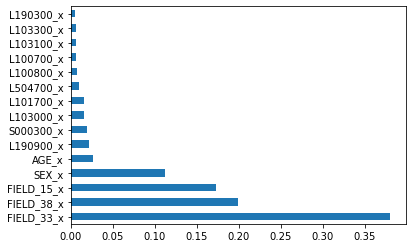

Index(['FIELD_33_x', 'FIELD_38_x', 'FIELD_15_x', 'SEX_x', 'AGE_x', 'L190900_x',
       'S000300_x', 'L103000_x', 'L101700_x', 'L504700_x', 'L100800_x',
       'L100700_x', 'L103100_x', 'L103300_x', 'L190300_x'],
      dtype='object')
1.0


In [67]:
ypred = rf.predict(xtest)

score = rf.score(xtest, ytest)
print(score)

feat_importances = pd.Series(rf.feature_importances_, index=xtest.columns)
feat_importances.nlargest(16).plot(kind="barh")
plt.show()

print(feat_importances.nlargest(16).index)

print(np.sum(feat_importances.nlargest(16)))

In [68]:
from sklearn.metrics import confusion_matrix

confusion_matrix(ytest, ypred)

array([[50,  0],
       [49,  1]], dtype=int64)

In [75]:
from sklearn.svm import SVC

scv_12=SVC(C=70, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3,  
    kernel='linear', max_iter=-1, probability=True, random_state=42,
    shrinking=True, tol=0.001, verbose=False)


In [76]:
scv_12.fit(xtrain, ytrain)

SVC(C=70, kernel='linear', probability=True, random_state=42)

In [77]:
ypred = scv_12.predict(xtest)
print("Accuracy = ", m.accuracy_score(ytest, ypred))

Accuracy =  0.66


In [78]:
confmatrx = pd.DataFrame(
    m.confusion_matrix(ytest, ypred),
    columns=["Normal", "Prediabetes", "diabetes"],
    index=["Normal", "Prediabetes", "diabetes"],
)
confmatrx.head()

ValueError: Shape of passed values is (2, 2), indices imply (3, 3)

In [ ]:
print(m.classification_report(ytest, ypred))

In [ ]:
xgb_model_12 = xgb.XGBClassifier( random_state=randomseed))
xgb_model_12.fit(xtrain, ytrain)

In [ ]:
ypred = xgb_model_12.predict(xtest)
print("Accuracy = ", m.accuracy_score(ytest, ypred))

In [ ]:
confmatrx = pd.DataFrame(
    m.confusion_matrix(ytest, ypred),
    columns=["Normal", "Prediabetes", "diabetes"],
    index=["Normal", "Prediabetes", "diabetes"],
)
confmatrx.head()

In [ ]:
print(m.classification_report(ytest, ypred))